### 1. Dataset Preparation

Import libraries and load dataset

In [2]:
import matplotlib.pyplot as plt
import datetime as date
import pandas as pd
import numpy as np
import seaborn as sns
import random
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("Dataset/modified/train.csv", parse_dates=["activation_date"])

In [4]:
pr_train = pd.read_csv("Dataset/modified/periods_train.csv", 
                       parse_dates=["activation_date", "date_from", "date_to"])

In [5]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

In [6]:
pr_train.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


### 2. Feature Engineering
Create extra features:
1. WeekDay - Day of th week when the Ad was activated
2. Month - Month when the Ad was activated
3. MonthDay - Day of the month when the Ad was activated
4. Description_len - Total length of words in description
5. Title_len - Total lenght in title
6. Total_period - Total number of days for which the Ad was run
7. Deal_Class - A bin variable which is 1 when the deal probability is > 0.5, else 0

In [5]:
train_df["WeekDay"] = train_df.activation_date.dt.weekday

In [6]:
train_df["Month"] = train_df.activation_date.dt.month
train_df["Day"] = train_df.activation_date.dt.day

In [7]:
# fill na for description before counting
train_df["description"] = train_df['description'].fillna(" ")
train_df["description_len"] = train_df['description'].apply(lambda x: len(x.split()))

#fill na for title before counting
train_df['title'] = train_df['title'].fillna(" ")
train_df["title_len"] = train_df['title'].apply(lambda x: len(x.split()))

In [8]:
pr_train['total_period'] = pr_train['date_to'] - pr_train['date_from']

In [9]:
daymap = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
train_df['weekday_en'] = train_df['WeekDay'].apply(lambda x: daymap[x])

In [10]:
train_df['deal_class'] = train_df['deal_probability'].apply(
    lambda x: ">=0.5" if x >= 0.5 else "<0.5")

In [11]:
interval = (-0.99, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.1)
cats = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5',
       '0.5-0.6', '0.6-0.7', '0.7-0.8','0.8-0.9', '0.9-1.0']

train_df['deal_class_2'] = pd.cut(train_df.deal_probability, interval, labels=cats)

### 3. Translating Columns
Translating columns in Russian to English using yandex and SRK's kernel

In [79]:
parent_category_name_map = {"Личные вещи" : "Personal belongings",
                            "Для дома и дачи" : "For the home and garden",
                            "Бытовая электроника" : "Consumer electronics",
                            "Недвижимость" : "Real estate",
                            "Хобби и отдых" : "Hobbies & leisure",
                            "Транспорт" : "Transport",
                            "Услуги" : "Services",
                            "Животные" : "Animals",
                            "Для бизнеса" : "For business"}

region_map = {"Свердловская область" : "Sverdlovsk oblast",
            "Самарская область" : "Samara oblast",
            "Ростовская область" : "Rostov oblast",
            "Татарстан" : "Tatarstan",
            "Волгоградская область" : "Volgograd oblast",
            "Нижегородская область" : "Nizhny Novgorod oblast",
            "Пермский край" : "Perm Krai",
            "Оренбургская область" : "Orenburg oblast",
            "Ханты-Мансийский АО" : "Khanty-Mansi Autonomous Okrug",
            "Тюменская область" : "Tyumen oblast",
            "Башкортостан" : "Bashkortostan",
            "Краснодарский край" : "Krasnodar Krai",
            "Новосибирская область" : "Novosibirsk oblast",
            "Омская область" : "Omsk oblast",
            "Белгородская область" : "Belgorod oblast",
            "Челябинская область" : "Chelyabinsk oblast",
            "Воронежская область" : "Voronezh oblast",
            "Кемеровская область" : "Kemerovo oblast",
            "Саратовская область" : "Saratov oblast",
            "Владимирская область" : "Vladimir oblast",
            "Калининградская область" : "Kaliningrad oblast",
            "Красноярский край" : "Krasnoyarsk Krai",
            "Ярославская область" : "Yaroslavl oblast",
            "Удмуртия" : "Udmurtia",
            "Алтайский край" : "Altai Krai",
            "Иркутская область" : "Irkutsk oblast",
            "Ставропольский край" : "Stavropol Krai",
            "Тульская область" : "Tula oblast"}


category_map = {"Одежда, обувь, аксессуары":"Clothing, shoes, accessories",
"Детская одежда и обувь":"Children's clothing and shoes",
"Товары для детей и игрушки":"Children's products and toys",
"Квартиры":"Apartments",
"Телефоны":"Phones",
"Мебель и интерьер":"Furniture and interior",
"Предложение услуг":"Offer services",
"Автомобили":"Cars",
"Ремонт и строительство":"Repair and construction",
"Бытовая техника":"Appliances",
"Товары для компьютера":"Products for computer",
"Дома, дачи, коттеджи":"Houses, villas, cottages",
"Красота и здоровье":"Health and beauty",
"Аудио и видео":"Audio and video",
"Спорт и отдых":"Sports and recreation",
"Коллекционирование":"Collecting",
"Оборудование для бизнеса":"Equipment for business",
"Земельные участки":"Land",
"Часы и украшения":"Watches and jewelry",
"Книги и журналы":"Books and magazines",
"Собаки":"Dogs",
"Игры, приставки и программы":"Games, consoles and software",
"Другие животные":"Other animals",
"Велосипеды":"Bikes",
"Ноутбуки":"Laptops",
"Кошки":"Cats",
"Грузовики и спецтехника":"Trucks and buses",
"Посуда и товары для кухни":"Tableware and goods for kitchen",
"Растения":"Plants",
"Планшеты и электронные книги":"Tablets and e-books",
"Товары для животных":"Pet products",
"Комнаты":"Room",
"Фототехника":"Photo",
"Коммерческая недвижимость":"Commercial property",
"Гаражи и машиноместа":"Garages and Parking spaces",
"Музыкальные инструменты":"Musical instruments",
"Оргтехника и расходники":"Office equipment and consumables",
"Птицы":"Birds",
"Продукты питания":"Food",
"Мотоциклы и мототехника":"Motorcycles and bikes",
"Настольные компьютеры":"Desktop computers",
"Аквариум":"Aquarium",
"Охота и рыбалка":"Hunting and fishing",
"Билеты и путешествия":"Tickets and travel",
"Водный транспорт":"Water transport",
"Готовый бизнес":"Ready business",
"Недвижимость за рубежом":"Property abroad"}

In [80]:
train_df['region_en'] = train_df['region'].apply(lambda x: region_map[x])
train_df['parent_category_name_en'] = train_df['parent_category_name'].apply(
lambda x: parent_category_name_map[x])
train_df['category_name_en'] = train_df['category_name'].apply(
lambda x: category_map[x])

In [16]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,Month,Day,description_len,title_len,weekday_en,deal_class,deal_class_2,region_en,parent_category_name_en,category_name_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,3,28,7,3,Mon,<0.5,0.1-0.2,Sverdlovsk oblast,Personal belongings,Children's products and toys
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,3,26,7,3,Sat,<0.5,0-0.1,Samara oblast,For the home and garden,Furniture and interior
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,3,20,17,2,Sun,<0.5,0.4-0.5,Rostov oblast,Consumer electronics,Audio and video
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,3,25,3,1,Fri,>=0.5,0.8-0.9,Tatarstan,Personal belongings,Children's products and toys
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,3,16,4,3,Wed,<0.5,0.2-0.3,Volgograd oblast,Transport,Cars


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 29 columns):
item_id                    1503424 non-null object
user_id                    1503424 non-null object
region                     1503424 non-null object
city                       1503424 non-null object
parent_category_name       1503424 non-null object
category_name              1503424 non-null object
param_1                    1441848 non-null object
param_2                    848882 non-null object
param_3                    640859 non-null object
title                      1503424 non-null object
description                1503424 non-null object
price                      1418062 non-null float64
item_seq_number            1503424 non-null int64
activation_date            1503424 non-null datetime64[ns]
user_type                  1503424 non-null object
image                      1390836 non-null object
image_top_1                1390836 non-null float64
deal_probabil

In [19]:
pr_train.head()

,item_id,activation_date,date_from,date_to,total_period
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1 days
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3 days
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13 days
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9 days
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13 days


In [20]:
pr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16687412 entries, 0 to 16687411
Data columns (total 5 columns):
item_id            object
activation_date    datetime64[ns]
date_from          datetime64[ns]
date_to            datetime64[ns]
total_period       timedelta64[ns]
dtypes: datetime64[ns](3), object(1), timedelta64[ns](1)
memory usage: 636.6+ MB


In [21]:
# pickle data
import pickle

In [22]:
with open("Dataset/modified/modified_train.pickle", "wb") as f:
    pickle.dump(train_df, f)
with open("Dataset/modified/modified_period_train.pickle", "wb") as f:
    pickle.dump(pr_train, f)

### 4. Variables distributions

#### 4.1. distribution of deal probability

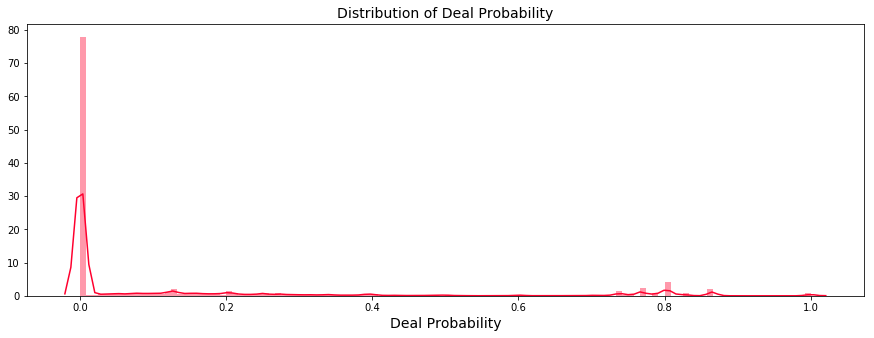

In [23]:
plt.figure(figsize=(15, 5))
sns.distplot(train_df["deal_probability"].values, bins=120, color='#ff002e')
plt.xlabel('Deal Probability', fontsize=14)
plt.title("Distribution of Deal Probability", fontsize=14)
plt.show()

In [25]:
from collections import Counter

In [25]:
c = Counter(train_df["deal_class_2"])
[(i, c[i], round(c[i] / len(train_df) * 100.0,2)) for i in c]

[('0.1-0.2', 126144, 8.39),
 ('0-0.1', 1054761, 70.16),
 ('0.4-0.5', 19926, 1.33),
 ('0.8-0.9', 84022, 5.59),
 ('0.2-0.3', 76809, 5.11),
 ('0.5-0.6', 9128, 0.61),
 ('0.3-0.4', 48030, 3.19),
 ('0.7-0.8', 68946, 4.59),
 ('0.6-0.7', 5582, 0.37),
 ('0.9-1.0', 10076, 0.67)]

From the probabily distribution graph and the counter, it is clear that majority of the items have very low deal probability (class imbalance, if we are considering this  as a classification problem).  About 70% of deals has probability 0 - 0.1.

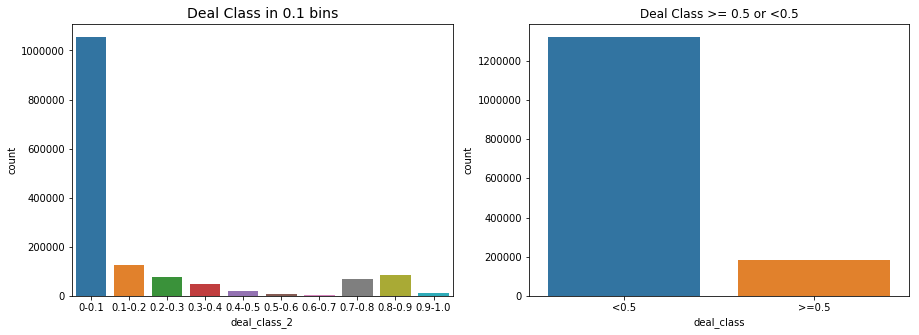

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
#plt.figure(figsize=(15, 5))

sns.countplot(x="deal_class_2", data=train_df, ax=axes[0])
axes[0].set_title("Deal Class in 0.1 bins", fontsize=14)

sns.countplot(x="deal_class", data=train_df, ax=axes[1])
axes[1].set_title("Deal Class >= 0.5 or <0.5")

plt.show()

#### 4.2 Distribution of parent category

Text(0.5,1,'Distribution of Parent Category')

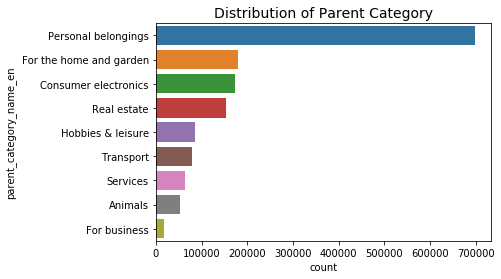

In [51]:
#fig = plt.figure(figsize=(15, 8))
ax = sns.countplot(y="parent_category_name_en", data=train_df, order=train_df["parent_category_name_en"].value_counts().index)
ax.set_title("Distribution of Parent Category", fontsize = 14)

In [45]:
c2 = Counter(train_df["parent_category_name_en"])
[(i, c2[i], round(c2[i] / len(train_df) * 100.0,2)) for i in c2]

[('Personal belongings', 697623, 46.4),
 ('For the home and garden', 178823, 11.89),
 ('Consumer electronics', 173008, 11.51),
 ('Transport', 79839, 5.31),
 ('Real estate', 153190, 10.19),
 ('Animals', 52470, 3.49),
 ('Hobbies & leisure', 86011, 5.72),
 ('Services', 64385, 4.28),
 ('For business', 18075, 1.2)]

Majority of the sales items are under "personal belongings" with almost 700K items or 46.4% of the total items. Home and Garden, Consumer electronics and Real estate are also popular (11.89%, 11.51% and 1

#### 4.3 Distribution of category

Text(0.5,1,'Distribution of Category')

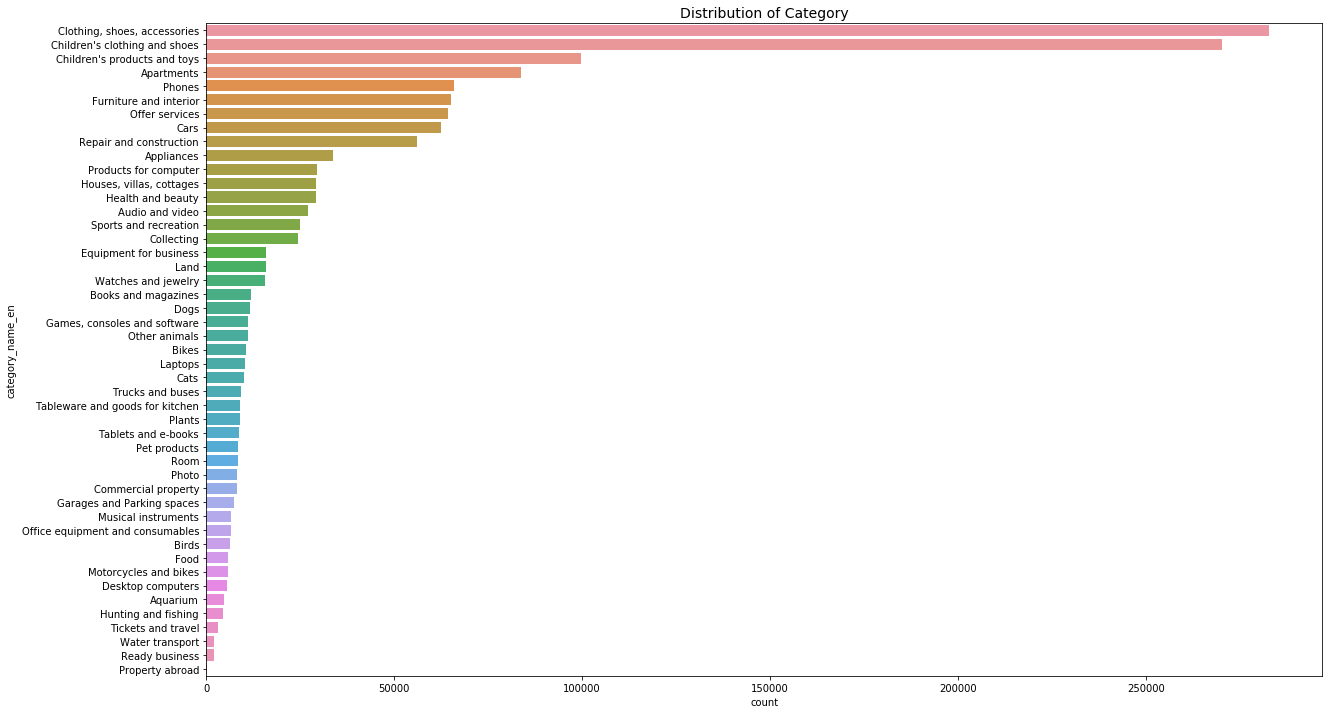

In [50]:
figure = plt.figure(figsize=(20,12))
ax = sns.countplot(y="category_name_en", data=train_df, order = train_df["category_name_en"].value_counts().index)
ax.set_title("Distribution of Category", fontsize = 14)

In [ ]:
c3 = Counter(train_df["category_name_en"])

In [62]:
c3 = sorted(c3.items(), key=lambda i:i[1], reverse=True)

In [65]:
[(name, count, round(count/ len(train_df) * 100.0,2)) for (name,count) in c3]

[('Clothing, shoes, accessories', 282753, 18.81),
 ("Children's clothing and shoes", 270359, 17.98),
 ("Children's products and toys", 99747, 6.63),
 ('Apartments', 83670, 5.57),
 ('Phones', 65944, 4.39),
 ('Furniture and interior', 65035, 4.33),
 ('Offer services', 64385, 4.28),
 ('Cars', 62494, 4.16),
 ('Repair and construction', 56201, 3.74),
 ('Appliances', 33705, 2.24),
 ('Products for computer', 29565, 1.97),
 ('Houses, villas, cottages', 29244, 1.95),
 ('Health and beauty', 29198, 1.94),
 ('Audio and video', 27036, 1.8),
 ('Sports and recreation', 24881, 1.65),
 ('Collecting', 24346, 1.62),
 ('Equipment for business', 16047, 1.07),
 ('Land', 16038, 1.07),
 ('Watches and jewelry', 15566, 1.04),
 ('Books and magazines', 11819, 0.79),
 ('Dogs', 11612, 0.77),
 ('Games, consoles and software', 11167, 0.74),
 ('Other animals', 11040, 0.73),
 ('Bikes', 10638, 0.71),
 ('Laptops', 10297, 0.68),
 ('Cats', 9951, 0.66),
 ('Trucks and buses', 9394, 0.62),
 ('Tableware and goods for kitchen',

#### 4.4 Distribution of Region

Text(0.5,1,'Distribution of Region')

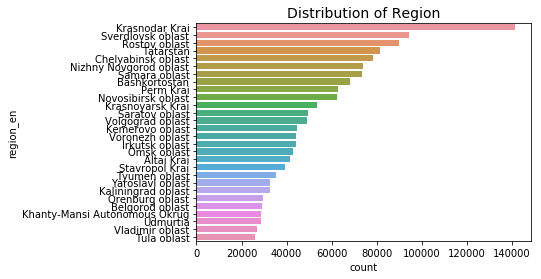

In [23]:
ax = sns.countplot(y="region_en", data=train_df, order = train_df["region_en"].value_counts().index)
ax.set_title("Distribution of Region", fontsize = 14)

In [26]:
c4 = Counter(train_df["region_en"])
c4 = sorted(c4.items(), key=lambda i:i[1], reverse=True)
[(name, count, round(count/ len(train_df) * 100.0,2)) for (name,count) in c4]

[('Krasnodar Krai', 141416, 9.41),
 ('Sverdlovsk oblast', 94475, 6.28),
 ('Rostov oblast', 89995, 5.99),
 ('Tatarstan', 81284, 5.41),
 ('Chelyabinsk oblast', 78339, 5.21),
 ('Nizhny Novgorod oblast', 73643, 4.9),
 ('Samara oblast', 73407, 4.88),
 ('Bashkortostan', 68291, 4.54),
 ('Perm Krai', 62704, 4.17),
 ('Novosibirsk oblast', 62486, 4.16),
 ('Krasnoyarsk Krai', 53442, 3.55),
 ('Saratov oblast', 49645, 3.3),
 ('Volgograd oblast', 48998, 3.26),
 ('Kemerovo oblast', 44635, 2.97),
 ('Voronezh oblast', 44116, 2.93),
 ('Irkutsk oblast', 44030, 2.93),
 ('Omsk oblast', 42939, 2.86),
 ('Altai Krai', 41520, 2.76),
 ('Stavropol Krai', 39187, 2.61),
 ('Tyumen oblast', 35411, 2.36),
 ('Yaroslavl oblast', 32814, 2.18),
 ('Kaliningrad oblast', 32756, 2.18),
 ('Orenburg oblast', 29303, 1.95),
 ('Belgorod oblast', 28868, 1.92),
 ('Khanty-Mansi Autonomous Okrug', 28709, 1.91),
 ('Udmurtia', 28537, 1.9),
 ('Vladimir oblast', 26741, 1.78),
 ('Tula oblast', 25733, 1.71)]

#### 4.5 Param values

In [27]:
c_param_1 = Counter(train_df["param_1"])
c_param_1.most_common()

[('Женская одежда', 226289),
 ('Для девочек', 151979),
 ('Для мальчиков', 117772),
 ('Продам', 113764),
 (nan, 61576),
 ('С пробегом', 61024),
 ('Аксессуары', 38568),
 ('Мужская одежда', 35716),
 ('Другое', 27874),
 ('Игрушки', 26442),
 ('Детские коляски', 26248),
 ('Сдам', 23535),
 ('Ремонт, строительство', 21444),
 ('Стройматериалы', 20197),
 ('iPhone', 18381),
 ('Кровати, диваны и кресла', 17419),
 ('Инструменты', 15904),
 ('Для кухни', 15721),
 ('Комплектующие', 15085),
 ('Детская мебель', 14251),
 ('Шкафы и комоды', 11417),
 ('Приборы и аксессуары', 11200),
 ('Для дома', 10064),
 ('Транспорт, перевозки', 9689),
 ('Товары для кормления', 8543),
 ('Samsung', 8330),
 ('Сниму', 8270),
 ('Книги', 8081),
 ('Телевизоры и проекторы', 7729),
 ('Велосипеды и самокаты', 7195),
 ('Предметы интерьера, искусство', 7109),
 ('Другая', 7029),
 ('Косметика', 6636),
 ('Постельные принадлежности', 6596),
 ('С/х животные', 6363),
 ('Столы и стулья', 6197),
 ('Планшеты', 6166),
 ('Фитнес и тренажёры', 

In [28]:
len(c_param_1) # 371 unique values for param_1 (not counting nan)

372

In [30]:
c_param_2 = Counter(train_df["param_2"])
c_param_2.most_common()

[(nan, 654542),
 ('Обувь', 150450),
 ('Верхняя одежда', 141860),
 ('Платья и юбки', 69483),
 ('Другое', 36284),
 ('Трикотаж', 31684),
 ('Брюки', 25807),
 ('1', 23426),
 ('2', 22921),
 ('На длительный срок', 22096),
 ('Дом', 20550),
 ('ВАЗ (LADA)', 19442),
 ('Комбинезоны и боди', 17633),
 ('3', 13006),
 ('Поселений (ИЖС)', 10611),
 ('Пиджаки и костюмы', 10329),
 ('Рубашки и блузки', 10079),
 ('Шапки, варежки, шарфы', 9389),
 ('Джинсы', 9141),
 ('Гараж', 6954),
 ('Чехлы и плёнки', 6886),
 ('Строительство домов, коттеджей', 6635),
 ('Дача', 6272),
 ('Стиральные машины', 5602),
 ('Отделочные работы', 5546),
 ('Свадебные платья', 5396),
 ('Холодильники и морозильные камеры', 5283),
 ('Сельхозназначения (СНТ, ДНП)', 4743),
 ('Мелкая кухонная техника', 4594),
 ('Топы и футболки', 4580),
 ('Плиты', 3698),
 ('Toyota', 3293),
 ('Коммерческие перевозки', 3265),
 ('Ремонт квартиры', 3136),
 ('Трикотаж и футболки', 3104),
 ('Hyundai', 2899),
 ('Нижнее бельё', 2889),
 ('Видеокарты', 2833),
 ('ГАЗ', 

In [32]:
len(c_param_2) # 271 unique values for param_2, not counting nan

272

In [33]:
c_param_3 = Counter(train_df["param_3"])
c_param_3.most_common()

[(nan, 862565),
 ('Вторичка', 50615),
 ('42–44 (S)', 47915),
 ('44–46 (M)', 35854),
 ('86-92 см (1-2 года)', 29139),
 ('98-104 см (2-4 года)', 25774),
 ('74-80 см (7-12 мес)', 23708),
 ('Без размера', 19494),
 ('40–42 (XS)', 19041),
 ('110-116 см (4-6 лет)', 18896),
 ('46–48 (L)', 18783),
 ('62-68 см (2-6 мес)', 16728),
 ('38', 14884),
 ('37', 14373),
 ('122-128 см (6-8 лет)', 13457),
 ('36', 11599),
 ('Новостройка', 11000),
 ('1', 10138),
 ('39', 10057),
 ('48–50 (XL)', 10020),
 ('134-140 см (8-10 лет)', 9688),
 ('> 50 (XXL)', 9508),
 ('146-152 см (10-12 лет)', 8940),
 ('25', 6786),
 ('22', 6765),
 ('23', 6695),
 ('21', 6634),
 ('26', 6442),
 ('2', 6070),
 ('24', 6034),
 ('27', 5627),
 ('< 19', 5617),
 ('40', 5365),
 ('28', 5136),
 ('20', 4975),
 ('46–48 (M)', 4840),
 ('48–50 (L)', 4574),
 ('29', 4055),
 ('50-56 cм (0-2 мес)', 4005),
 ('30', 3831),
 ('Кирпичный', 3682),
 ('< 35', 3568),
 ('50–52 (XL)', 3322),
 ('31', 2976),
 ('32', 2955),
 ('На длительный срок', 2743),
 ('44–46 (S)', 

In [35]:
len(c_param_3) 
# 1219 unique values, not counting nan, but some of them are really low`

1220

#### 4.6 Month day and week day the items are activated

Text(0.5,1,'Distribution of Days')

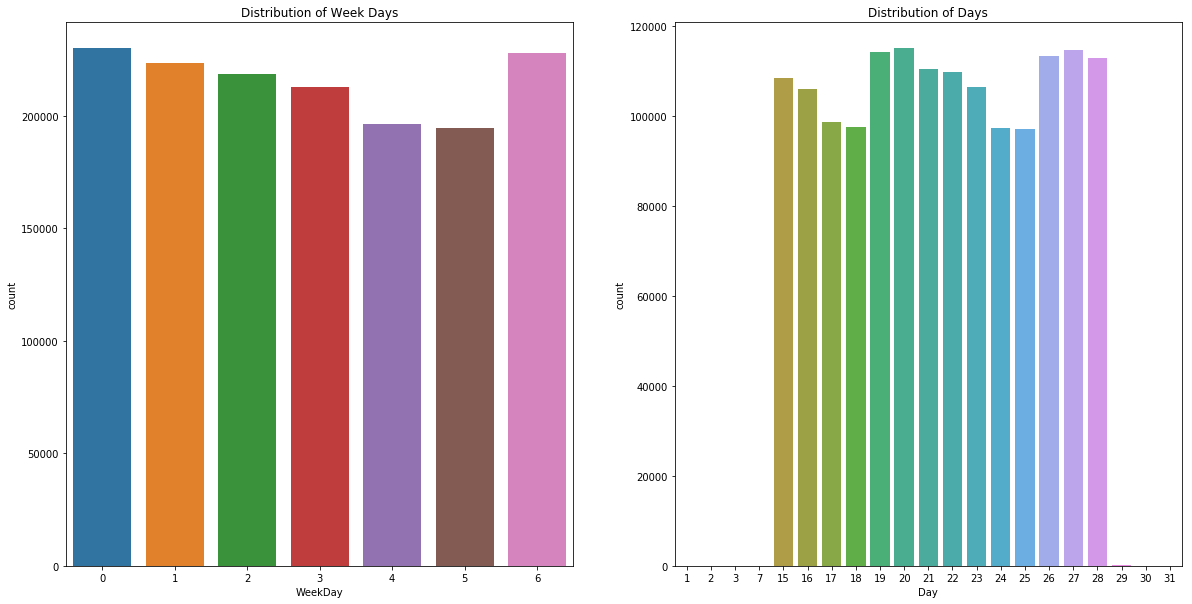

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.countplot(x="WeekDay", data=train_df, ax=axes[0])
axes[0].set_title("Distribution of Week Days")
sns.countplot(x="Day", data=train_df, ax=axes[1])
axes[1].set_title("Distribution of Days")

In [46]:
c_weekday = Counter(train_df["WeekDay"])
c_weekday.most_common()

[(0, 230055),
 (6, 227932),
 (1, 223420),
 (2, 218515),
 (3, 212715),
 (4, 196126),
 (5, 194661)]

In [47]:
c_day = Counter(train_df["Day"])
c_day.most_common()

[(20, 115190),
 (27, 114863),
 (19, 114416),
 (26, 113513),
 (28, 112885),
 (21, 110535),
 (22, 109813),
 (15, 108615),
 (23, 106544),
 (16, 106168),
 (17, 98773),
 (18, 97554),
 (24, 97351),
 (25, 97104),
 (29, 87),
 (2, 3),
 (1, 3),
 (30, 3),
 (3, 2),
 (7, 1),
 (31, 1)]

#### 4.7 Length of title and description

In [21]:
# bin description length
bins = range(0, train_df["description_len"].max(), 10)
train_df["description_len_bucket"] = pd.cut(train_df['description_len'], bins)

Text(0.5,1,'Description Length')

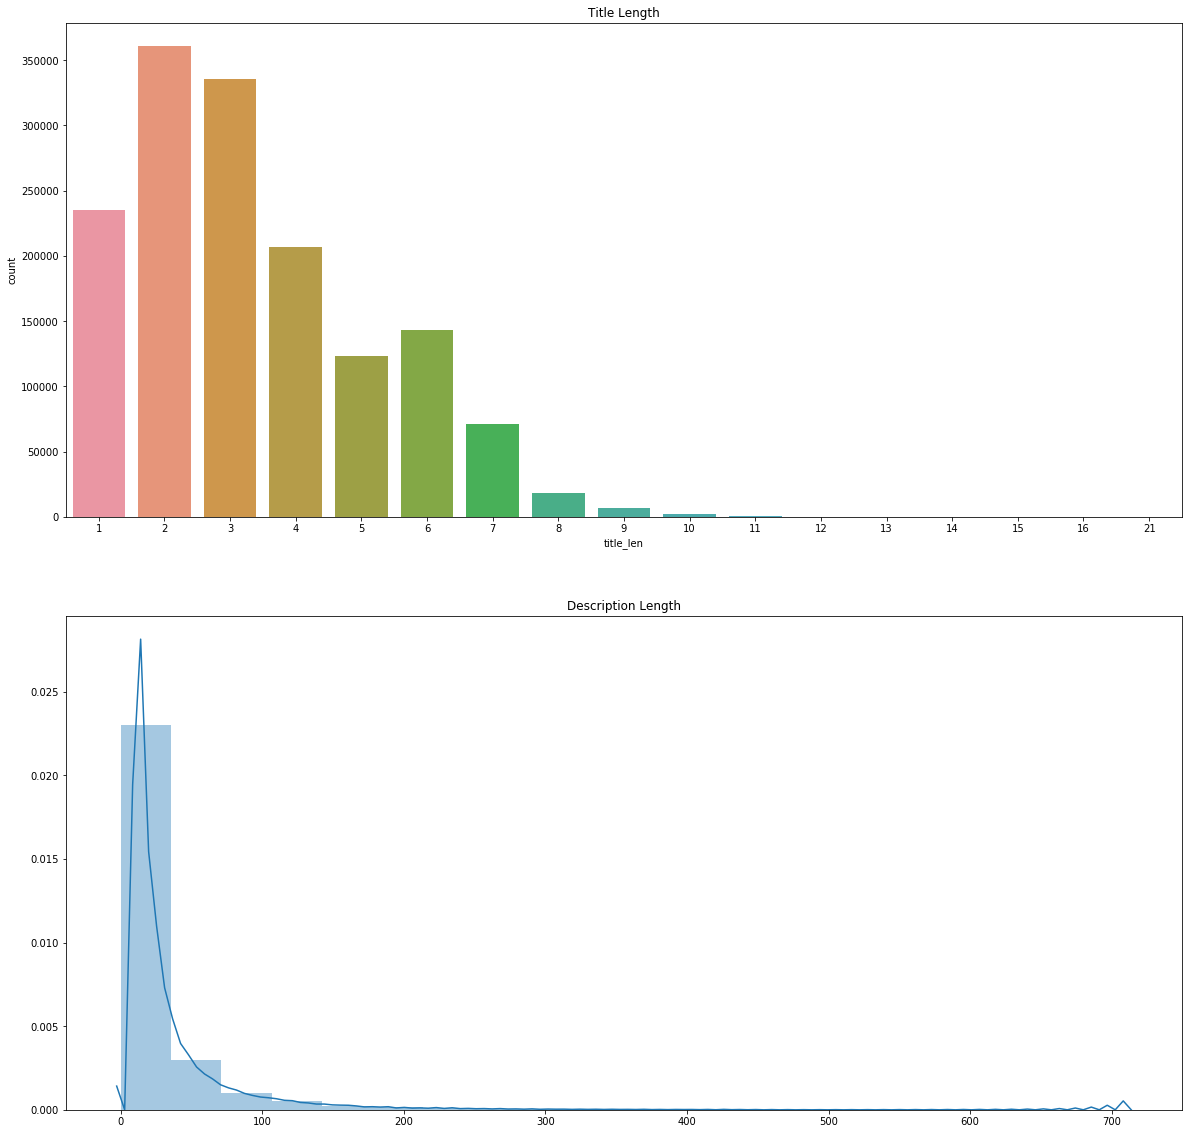

In [68]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize= (20, 20))

sns.countplot(x="title_len", data=train_df, ax=axes[0])
axes[0].set_title("Title Length")

#sns.countplot(x="description_len_bucket", data=train_df, ax=axes[1])
sns.distplot(train_df["description_len"].values, bins=20, ax=axes[1])
axes[1].set_title("Description Length")

In [22]:
c_description_len = Counter(train_df["description_len_bucket"])
c_description_len.most_common()

[(Interval(0, 10, closed='right'), 542657),
 (Interval(10, 20, closed='right'), 357820),
 (Interval(20, 30, closed='right'), 164033),
 (nan, 116277),
 (Interval(30, 40, closed='right'), 87770),
 (Interval(40, 50, closed='right'), 53783),
 (Interval(50, 60, closed='right'), 36834),
 (Interval(60, 70, closed='right'), 26996),
 (Interval(70, 80, closed='right'), 20068),
 (Interval(80, 90, closed='right'), 15892),
 (Interval(90, 100, closed='right'), 12263),
 (Interval(100, 110, closed='right'), 10773),
 (Interval(110, 120, closed='right'), 8724),
 (Interval(120, 130, closed='right'), 7149),
 (Interval(130, 140, closed='right'), 5648),
 (Interval(140, 150, closed='right'), 4871),
 (Interval(150, 160, closed='right'), 4118),
 (Interval(160, 170, closed='right'), 3661),
 (Interval(180, 190, closed='right'), 2684),
 (Interval(170, 180, closed='right'), 2640),
 (Interval(190, 200, closed='right'), 1941),
 (Interval(200, 210, closed='right'), 1749),
 (Interval(220, 230, closed='right'), 1640),


In [13]:
# look at distribution of descriptions with less than 200 words
sub_df = train_df[train_df["description_len"] < 201]

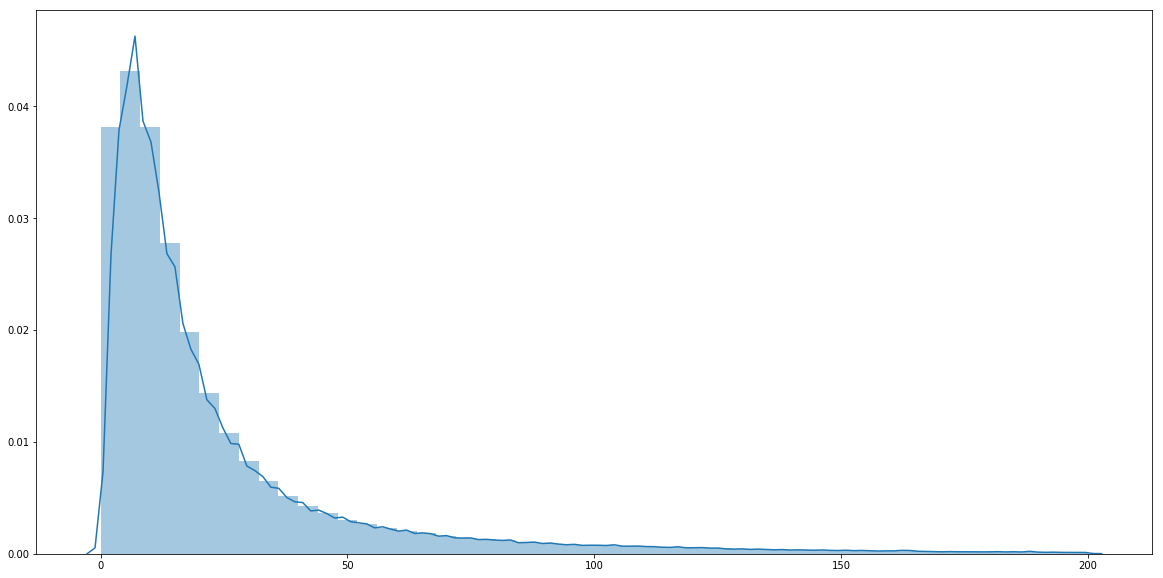

In [18]:
fig = plt.figure(figsize=(20, 10))
sns.distplot(sub_df["description_len"].values, bins=50)
plt.show()

#### 4.8 User type

In [24]:
c_user = Counter(train_df["user_type"])

In [29]:
labels = list(c_user.keys())
values = list(c_user.values())
labels, values

(['Private', 'Company', 'Shop'], [1075706, 347249, 80469])

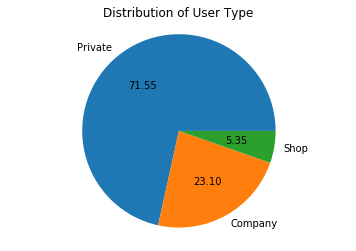

In [34]:
fig, ax = plt.subplots()
ax.pie(values, labels = labels, autopct='%1.2f')
ax.axis('equal')
plt.title("Distribution of User Type")
plt.show()

#### 4.9 Number of days ads were run

In [38]:
c_total_period = Counter(pr_train['total_period'])

In [49]:
labels = list(c_total_period.keys())

In [51]:
labels = [str(x).replace("00:00:00","").strip() for x in labels]

In [52]:
values = list(c_total_period.values())

In [59]:
labels, values

(['1 days',
  '3 days',
  '13 days',
  '9 days',
  '5 days',
  '6 days',
  '11 days',
  '12 days',
  '8 days',
  '7 days',
  '10 days',
  '4 days',
  '2 days',
  '0 days'],
 [900786,
  782614,
  6908202,
  691323,
  768530,
  819308,
  703991,
  710159,
  797584,
  812361,
  627634,
  798947,
  819488,
  546485])

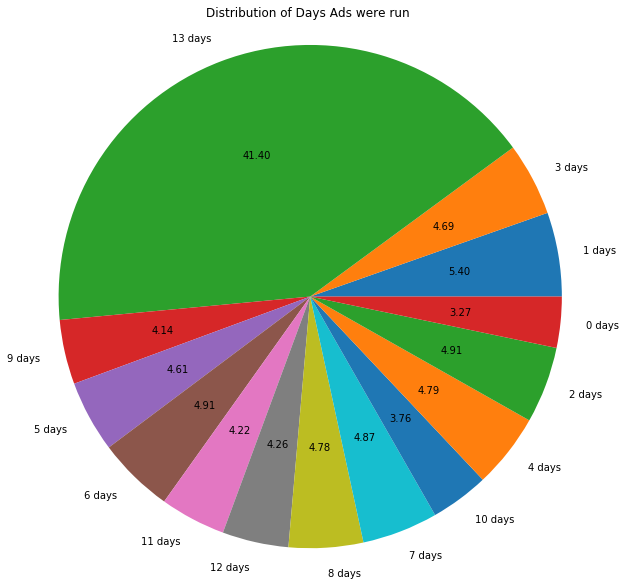

In [64]:
fig,ax = plt.subplots(figsize=(10, 10))
ax.pie(values, labels=labels, autopct='%1.2f')
ax.axis('equal')
plt.title("Distribution of Days Ads were run")
plt.show()

### 5.  Multi-Variate Analysis

In [73]:
corr = train_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

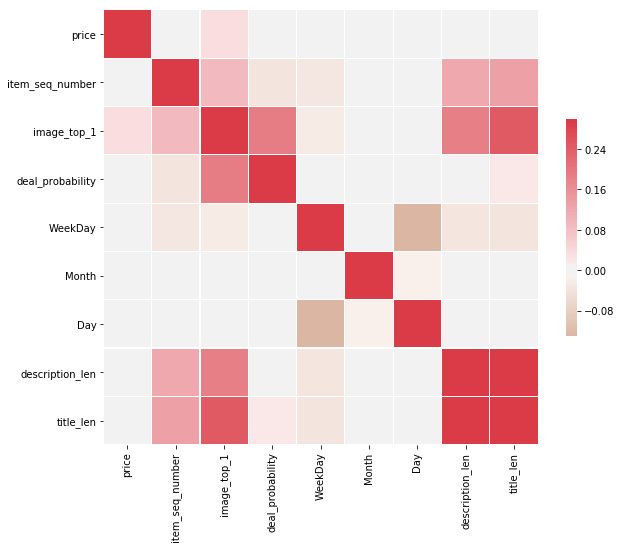

In [75]:
figure, axes = plt.subplots(figsize=(10,8))
cmap = sns.diverging_palette(30, 10, as_cmap=True)
sns.heatmap(corr, vmax=0.3, center=0, cmap=cmap, square=True, 
            linewidths=0.1, cbar_kws={"shrink": .5})

#### 5.2 Deal Probability Vs Parent Category and User Type

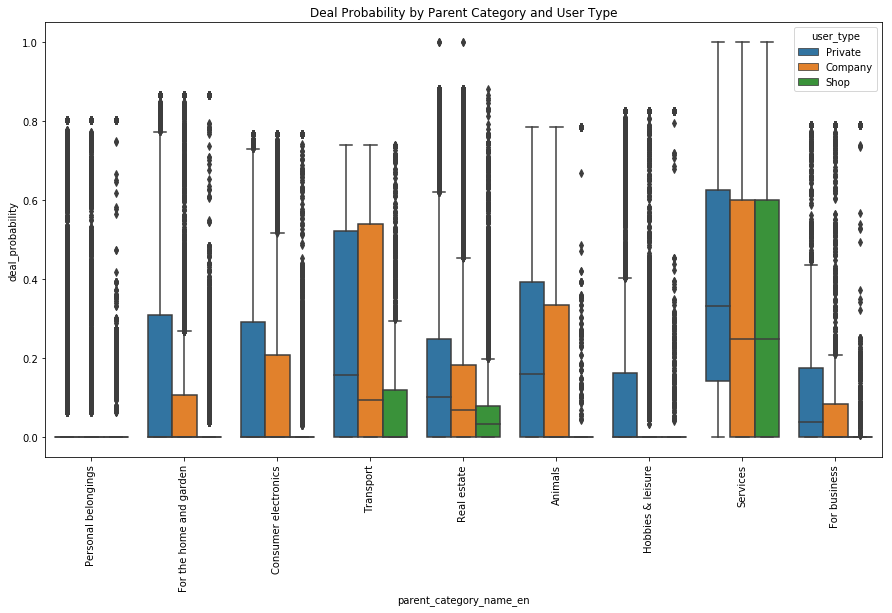

In [81]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", hue="user_type", data=train_df)
plt.title("Deal Probability by Parent Category and User Type")
plt.xticks(rotation="vertical")
plt.show()

#### 5.3 Deal Probability Vs Region and User Type

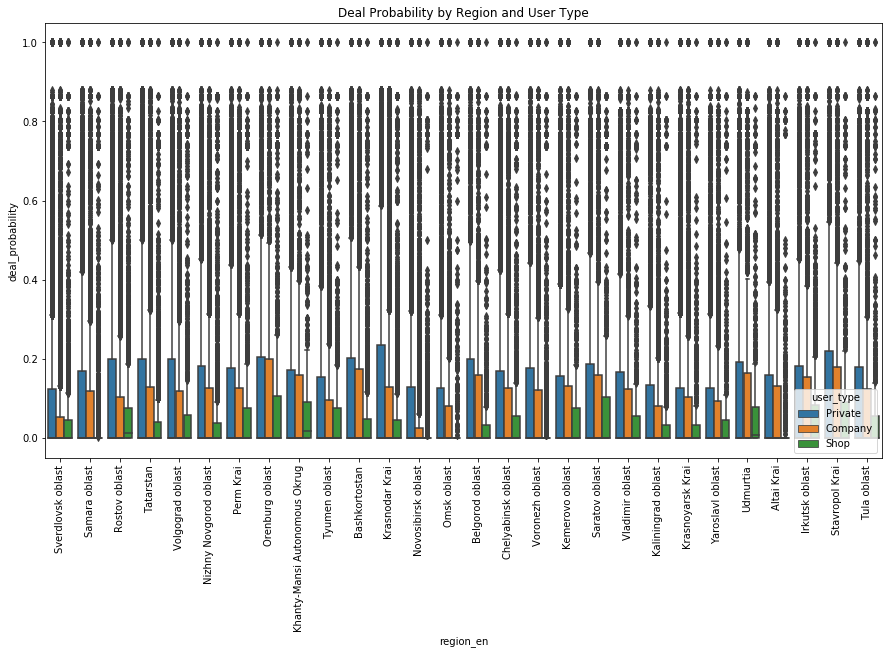

In [83]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="region_en", y="deal_probability", hue="user_type", data=train_df)
plt.title("Deal Probability by Region and User Type")
plt.xticks(rotation="vertical")
plt.show()

#### 5.4 Log of Price Vs Deal Probability

In [84]:
train_df['price_log'] = np.log(train_df['price']+1)

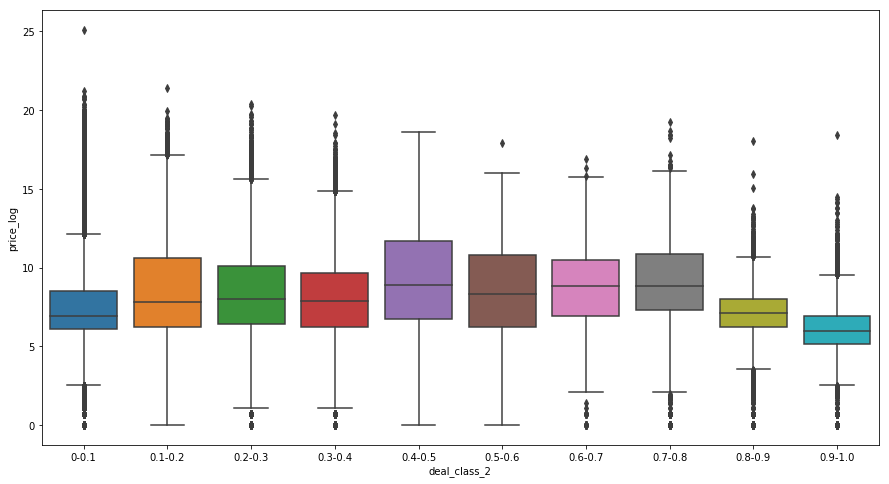

In [86]:
fig = plt.figure(figsize=(15,8))
sns.boxplot(x='deal_class_2', y='price_log', data=train_df)
ax.set_xlabel('The Deal Probability Class', fontsize=12)
ax.set_ylabel('Log of Price', fontsize=12)
plt.show()

#### 5.5 Number of items under different Parent Category vs Deal Class

In [87]:
cols = ['parent_category_name_en', 'deal_class_2']
colmap = sns.light_palette('#ff4284', as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]]).style.background_gradient(cmap=colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
parent_category_name_en,,,,,,,,,,
Animals,25379,5269,4511,7040,876,134,194,9067,0,0
Consumer electronics,111770,13321,9931,7681,1653,442,585,27625,0,0
For business,13325,1870,1078,119,115,120,53,1395,0,0
For the home and garden,118028,13115,9330,9063,1790,216,446,568,26267,0
Hobbies & leisure,64808,5436,3626,1868,660,143,193,243,9034,0
Personal belongings,579607,41554,21169,4110,1357,554,1073,787,47412,0
Real estate,89557,26407,15823,6078,4165,2095,1793,6258,1009,5
Services,15235,11190,5434,7592,4531,4347,408,5277,300,10071
Transport,37052,7982,5907,4479,4779,1077,837,17726,0,0


#### 5.6 Number of items in different Region Vs Deal Probability classes

In [115]:
cols = ['region_en', 'deal_class_2']
colmap = sns.light_palette('green', as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]]).style.background_gradient(cmap=colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
region_en,,,,,,,,,,
Altai Krai,29045,3720,2249,1386,400,187,140,1501,2724,168
Bashkortostan,45528,6350,4309,2715,1208,537,258,3595,3225,566
Belgorod oblast,19820,2414,1543,1139,467,214,115,1456,1428,272
Chelyabinsk oblast,55044,6411,3691,2228,1002,394,302,3891,4983,393
Irkutsk oblast,30078,4244,2731,1485,565,260,170,1708,2511,278
Kaliningrad oblast,24045,2362,1318,770,285,147,104,1204,2380,141
Kemerovo oblast,31443,3884,2296,1420,458,214,152,1821,2787,160
Khanty-Mansi Autonomous Okrug,19640,2647,1671,957,399,175,127,1254,1633,206
Krasnodar Krai,95227,13627,8146,5540,2434,1228,571,7205,5969,1469


#### 5.7 Mean price per region per deal probability

In [120]:
cols =["region_en", "deal_class_2"]
colmap = sns.light_palette('lightblue', as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]], values=train_df["price"],aggfunc=np.mean).style.background_gradient(cmap=colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
region_en,,,,,,,,,,
Altai Krai,139520,241047,164532,160111,229640,186680,140077,56895.4,2349.18,1409.62
Bashkortostan,156505,400596,423479,326262,443091,325506,346642,143529,2725.79,2407.84
Belgorod oblast,245734,363848,528683,619452,322764,279390,264434,114846,2681.47,548.265
Chelyabinsk oblast,179555,286963,225676,253050,155753,149820,289278,99990.7,16697.9,1381.57
Irkutsk oblast,2.97529e+06,421657,255886,172031,291346,283524,249241,76995.7,2913.65,6777.3
Kaliningrad oblast,204479,433950,328525,130876,89200.7,77604.5,89869.9,141754,2536.49,1233.66
Kemerovo oblast,197522,244413,186764,140881,216710,266470,104733,51420.6,2533.47,958.261
Khanty-Mansi Autonomous Okrug,314807,643927,443397,330952,470538,385145,209463,127779,3341.55,2858.96
Krasnodar Krai,964249,1.16846e+06,797848,378554,474004,353960,224454,137309,5436.47,4602.47


#### 5.9 Mean price vs parent category 

In [122]:
cols =["parent_category_name_en", "deal_class_2"]
colmap = sns.light_palette('orange', as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]], values=train_df["price"],aggfunc=np.mean).style.background_gradient(cmap=colmap)

deal_class_2,0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
parent_category_name_en,,,,,,,,,,
Animals,10968.5,75959.7,149274,73867.2,7956.85,6322.81,9203.1,9686.73,nan,nan
Consumer electronics,21735,11298.2,37995.4,9479.1,5593.81,5384.74,5846.66,6192.94,nan,nan
For business,656559,1.77255e+06,211492,125534,483170,66912.7,65434.1,41075.2,nan,nan
For the home and garden,19634.8,14776.9,96701.6,4829.24,4179.4,3693.2,3683.8,3921.79,6777.86,nan
Hobbies & leisure,10638.1,11368.6,123041,227233,4658.08,5350.71,4732.84,4809.57,4221.58,nan
Personal belongings,7726.82,21109.3,12993.1,1932.68,1367.52,2134.06,1678.88,1951.85,1947.11,nan
Real estate,3.67403e+06,2.00383e+06,1.63045e+06,1.37823e+06,1.048e+06,768460,541365,530084,9609.62,2600
Services,5642.34,9144.52,4496.05,27387,10507.6,6456.59,1965.86,32992.7,4659.29,17555.8
Transport,513376,405049,348148,313173,235747,275043,329434,250397,nan,nan


In [128]:
# Mean Price Vs Weekday vs deal probability
cols =["WeekDay", "deal_class_2"]
colmap = sns.light_palette('coral', as_cmap=True)
pd.crosstab(train_df[cols[1]], train_df[cols[0]],values=train_df["price"], aggfunc=np.mean).style.background_gradient(cmap=colmap)

WeekDay,0,1,2,3,4,5,6
deal_class_2,,,,,,,
0-0.1,321024,298804,831512,292827,300121,198292,124626
0.1-0.2,480693,523608,577397,605502,509023,309944,294500
0.2-0.3,436363,444682,447296,400595,353929,276590,307210
0.3-0.4,252561,273565,262339,283773,228917,189160,175572
0.4-0.5,299864,263108,287928,392371,342880,222079,214680
0.5-0.6,239749,247597,276459,329257,251372,192623,198998
0.6-0.7,282264,244256,229113,241150,213032,203481,150047
0.7-0.8,112532,133105,134431,139930,141037,105210,95444.7
0.8-0.9,3241.96,2779.55,3683.81,2839.06,2829.84,2651.95,7666.78


In [129]:
# Mean Price Vs Weekday vs deal probability
cols =["WeekDay", "region_en"]
colmap = sns.light_palette('gold', as_cmap=True)
pd.crosstab(train_df[cols[0]], train_df[cols[1]],values=train_df["price"], aggfunc=np.mean).style.background_gradient(cmap=colmap)

region_en,Altai Krai,Bashkortostan,Belgorod oblast,Chelyabinsk oblast,Irkutsk oblast,Kaliningrad oblast,Kemerovo oblast,Khanty-Mansi Autonomous Okrug,Krasnodar Krai,Krasnoyarsk Krai,Nizhny Novgorod oblast,Novosibirsk oblast,Omsk oblast,Orenburg oblast,Perm Krai,Rostov oblast,Samara oblast,Saratov oblast,Stavropol Krai,Sverdlovsk oblast,Tatarstan,Tula oblast,Tyumen oblast,Udmurtia,Vladimir oblast,Volgograd oblast,Voronezh oblast,Yaroslavl oblast
WeekDay,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,152807,212574,271502,298181,269506,207494,169325,342472,1.09163e+06,246711,187636,133588,160029,202526,173821,363082,252271,152347,502436,161230,240854,186106,281044,219760,195487,201060,176245,138102
1,159328,217392,382709,182836,237050,239104,162886,328348,977182,208340,238005,144513,87303,208983,206728,368469,251395,132812,422957,129979,272753,220829,307002,350925,340071,166769,178230,169208
2,145595,235108,245912,165083,1.27309e+07,262531,169638,410670,944244,257401,220022,116216,91134.5,169821,239644,391150,200327,144082,358442,143781,243869,266671,441486,325151,223230,182382,198792,151637
3,154266,219215,226008,163161,296699,232516,178350,372090,844384,213036,483039,110066,86466.5,217370,201302,449813,304899,154810,354969,160295,242479,189227,366238,271150,233909,159022,173436,134327
4,138595,269475,191633,187788,224379,222971,164180,390712,926828,188399,153740,183171,153261,173291,219466,400138,240805,129321,395286,159697,282048,209730,303118,237333,295199,191103,144764,134032
5,76879.7,120803,357159,110658,183003,165610,359572,254542,662537,126246,121524,55054.6,66533.7,145842,93557.4,228871,173364,154799,252882,117099,169270,113212,121030,97875.5,115168,110693,124096,67950.8
6,140110,112572,165360,119715,106865,97779.9,81071.6,195147,402952,124899,88464.6,139429,45400.8,97060.9,87377.1,179153,153902,81084.9,187407,75244.2,125250,139298,148734,92474.6,105303,79089.2,116759,77793.2
